## Problem Overview
The goal of this project is to extend the newsvendor model in a few ways to make a better approximation of reality.
In our first extension, we will assume that if you don’t print enough newspapers to satisfy demand, then you can send a rush order to the printers to print all that you need. These rushed newspapers cost more to print, we will call the cost per rushed newspaper $g$, where $g>c$. Additionally, if you print more than the demand you must pay a disposal fee of $t$ dollars per newspaper. You could alternatively think about this as receiving money for taking excess newspapers to a recycling center if $t<0$, but for now we’ll think of $t>0$. Putting this together, the objective function is:

$$\max_q \frac{1}{n}\sum^n_{i=1}(pD_i-qc-g(D_i-q)^+-t(q-D_i)^+)$$
where $(x)^+=max(x,0)$. Part of this project will be to reformulate this as a linear program.

In our second extension of the NV model we will assume that price impacts demand linearly with error, $D_i=\beta_0+\beta_1p+\epsilon_i$, and jointly solve for the optimal price and quantity to print. This is in the model with disposal costs, and quick printing costs. To do this, you will be given a data set with price and demand data. You will fit a linear regression to this data, and you will assume the source of randomness is the residuals of this regression. This means once you find $\beta_0$ and $\beta_1$ you can find lots of demand data points for any one price: get all your residuals and plug them into the regression equation for that one price. That is, your data becomes just the residuals of your regression, instead of the original price/demand data. If you find $\beta_0 = 1000$ and $\beta_1 = −2$ and two of the residuals are 15 and -9, then for a price of \\$2 you get 2 demand data points of $1000-2*2+15=1011$ and $1000-2*2-9=9987$.

You can see that when demand becomes a function of price like this you must multiply $pD_i$ but this becomes $p(\beta_0+\beta_1p+\epsilon_i)$. This is then a quadratic function of $p$.

To solve these problems, you will have to create some dummy variables for each day, $h_i$, that represent some part of the objective; in class we let $h_i$ represent the entire profit for each day. In this problem, you should set $h_i$ to be the negative of cost on each day. Then the objective is the average of revenue plus negative cost, where the revenue part comes from $pD_i$ and the negative cost comes from $h_i$. This way the quadratic part would stay in the objective instead of going down to a constraint when price impacts demand. You still need 2 constraints for the negative cost dummy variables, but these are linear constraints instead of quadratic. This is a little tricky to formulate because the problem is a quadratic program, instead of a linear program. The reason we would define $h_i$ to be negative cost is that we’re maximizing over $h$, so we want negative costs to be as big as possible; we don’t want big costs. Also, the constraints need to be upper bounds on $h$, not lower bounds. You can see this by drawing a similar graph to the one we drew in class when we did the original NV problem. Remember that costs are always positive in this model, so negative costs are always negative. Set you lb accordingly.

In [1]:
## load in packages
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
# load original price-demand data
data = pd.read_csv("price_demand_data.csv")

### 1. Fit a linear regression model to this data set.

In [3]:
x = data.price
y = data.demand
# fit the linear regression
x = sm.add_constant(x)
lm = sm.OLS(y,x).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     159.3
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           3.51e-22
Time:                        22:14:02   Log-Likelihood:                -636.17
No. Observations:                  99   AIC:                             1276.
Df Residuals:                      97   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1924.7175    111.334     17.288      0.0

Di = 1924.718 + (-1367.713) * p


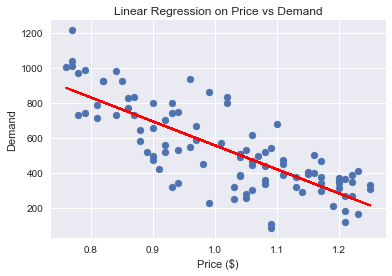

In [4]:
print('Di = {:.3f} + ({:.3f}) * p'.format(lm.params[0], lm.params[1]))

plt.scatter(data.price, y)
plt.plot(data.price, lm.predict(x), 'r')
plt.xlabel('Price ($)')
plt.ylabel('Demand')
plt.title('Linear Regression on Price vs Demand')
plt.show()

### 2. Let c=0.5, g=0.75, and t=0.15. Using the residuals, assume the price is p=1 and generate demand data.

In [5]:
df2 = data.copy()
df2['residual'] = lm.resid  # residuals from the linear regression model

di = []
p = 1  # fixed price

for i in range(len(df2)):
    # generate demand data using the linear model and its residuals
    demand = lm.params[0] + lm.params[1]*p + df2['residual'][i]
    di.append(demand)
demand_data = pd.DataFrame(np.array(di), columns=['demand_p=1'])
demand_data

,demand_p=1
0,351.385626
1,579.520247
2,472.219630
3,448.937249
4,673.748994
...,...
94,498.802628
95,669.103245
96,441.708501
97,858.354250


### 3. Solve the optimal quantity to produce when p=1. This is not quadratic at all, just an LP.

In [6]:
# parameters
p = 1
c = 0.5
g = 0.75
t = 0.15
n = len(demand_data)

If we introduce $h_i$ as in class, i.e., $h_i$ as the entire profit, then
$$\max_{h_i,q}\frac{1}{n}\sum_{i=1}^{n}h_i$$

If demand < printed, $h_i\leq D_i-qc-t(q-D_i)\Longrightarrow (t+c)q+h_i\leq (1+t)D_i$\
If demand > printed, $h_i\leq D_i-qc-g(D_i-q)\Longrightarrow (c-g)q+h_i\leq (1-g)D_i$\
$h_i\geq -inf$

In [7]:
# decision variables: q, h1, h2, ...
obj = np.zeros(n+1)
obj[1:] = 1/n

lb = np.zeros(n+1)
lb[1:] = -np.inf  # all h_i can be less than 0

rhs = np.zeros(2*n)
A = np.zeros((2*n, n+1))
for row in range(n):
    Di = demand_data['demand_p=1'][row]
    
    rhs[row*2] = (1+t)*Di
    rhs[row*2+1] = (1-g)*Di
    
    A[[row*2,row*2+1], 0] = t+c, c-g  # coefficient for q
    A[[row*2,row*2+1], row+1] = 1     # coefficinet for h_i

In [8]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj), lb=lb)
spMod_con = spMod.addConstr(A @ spMod_x <= rhs)
spMod.setObjective(obj @ spMod_x,sense=gp.GRB.MAXIMIZE)
spMod.Params.OutputFlag = 0
spMod.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [9]:
print('Optimal quantity:', spMod_x.x[0])

Optimal quantity: 471.8653795908935


In [10]:
print('Expected profit:', spMod.objVal)

Expected profit: 231.48366664714132


### 4. Now let price impact demand and solve the resulting QP. What are the optimal price and quantity to print?

$$\max_{h_i,q}\frac{1}{n}\sum_{i=1}^{n}\beta_0p+\beta_1p^2+\epsilon_ip+h_i$$
where $h_i = -(qc+g(D_i-q)^++t(q-D_i)^+)$

when demand < printed, $h_i\leq -(qc+t(q-D_i))$

when demand > printed, $h_i\leq -(qc+g(D_i-q))$

then we have:

$$h_i+(t+c)q-t\beta_1p\leq t\beta_0+t\epsilon_i$$
$$h_i+(c-g)q+g\beta_1p\leq -g\beta_0-g\epsilon_i$$
$$h_i\leq 0$$

Set the decision variables as $x=[p,q,h_1,...,h_n]$. 

$Q$ is an $j\times j$ matrix ($j=n+2$) where the first entry is $\beta_1$ and the rest entries are 0. 

linear term $c$ is a $j\times 1$ matrix: $c=[\beta_0+\frac{\sum\epsilon_i}{n},0,\frac{1}{n},\frac{1}{n},...,\frac{1}{n}]$

In [11]:
# parameters
# lm is the previous linear regression model on price and demand
beta0, beta1 = lm.params   
epsilon = lm.resid
c = 0.5  # cost for each newspaper printed in regular time
g = 0.75 # cost for each rushed newspaper, g>c
t = 0.15 # disposal fee for each overprinted newspaper t>0
n = len(data)

In [12]:
# decision variables: p, q, h1, ..., hn
Q = np.zeros((n+2, n+2))
Q[0,0] = beta1  # quadratic term

cvec = np.zeros(n+2)  # linear term
cvec[0] = beta0 + epsilon.mean()
cvec[2:] = 1/n

lb = np.zeros(n+2)  
ub = np.zeros(n+2)  # all h_i are less than 0
lb[2:] = -np.inf  
ub[:2] = np.inf     # p and q are non-negative

In [13]:
A = np.zeros((2*n, 2+n))
rhs = np.zeros(2*n)

for row in range(n):
    # for each row, index 0, 1, 'row'+2 => p, q, h_i
    A[[row*2, row*2+1], 0] = [-t*beta1, g*beta1]  # p
    A[[row*2, row*2+1], 1] = [t+c, c-g]  # q
    A[[row*2, row*2+1], row+2] = [1, 1]  # h_i
    
    rhs[row*2] = t*beta0 + t*epsilon[row]
    rhs[row*2+1] = -g*beta0 - g*epsilon[row]

In [14]:
spMod = gp.Model()
spMod_x = spMod.addMVar(n+2, lb=lb, ub=ub)
spMod_con = spMod.addConstr(A @ spMod_x <= rhs)
spMod.setMObjective(Q,cvec,0,sense=gp.GRB.MAXIMIZE)
spMod.Params.OutputFlag = 0
spMod.Params.NonConvex = 2  # prevent the error that Q is not PSD (negative diagonal entry)
spMod.optimize()

In [15]:
p_optim = float(spMod_x.x[0])
q = float(spMod_x.x[1])
profit = spMod.objVal
print('Optimal price: ${:.3f}\nQuantity to print: {:.1f}\nExpected profit: ${:.3f}'.format(p_optim, q, profit))

Optimal price: $0.954
Quantity to print: 535.3
Expected profit: $234.425


### 6. We are now interested to know how sensitive the optimal price and quantity are to our data set. Take a bootstrap sample of the original dataset. Go back and fit new beta’s to the new bootstrapped dataset and redo step 4. Find the optimal price and quantity.

In [16]:
def regression(data):
    '''
    input: a dataframe that has at least the following columns: price and demand
    output: a statsmodel object 
    '''
    x = data.price
    y = data.demand
    x = sm.add_constant(x)
    lm = sm.OLS(y,x).fit()
    return lm

In [17]:
def optimization(model, n, c=0.5, g=0.75, t=0.15):
    '''
    input: 
        model -> statsmodel object from function "regression"
        n -> data size
        c, g, and t -> costs
    output: 
        a list of optimal price, quantity, and expected profit
    '''
    beta0, beta1 = model.params
    epsilon = model.resid
    
    # decision variables: p, q, h1, ..., hn
    Q = np.zeros((n+2, n+2))  # quadratic term
    Q[0,0] = beta1   

    cvec = np.zeros(n+2)      # linear term
    cvec[0] = beta0 + epsilon.mean()
    cvec[2:] = 1/n

    lb = np.zeros(n+2)
    ub = np.zeros(n+2)  # all h_i are less than 0
    lb[2:] = -np.inf
    ub[:2] = np.inf     # p and q are non-negative
    
    A = np.zeros((2*n, 2+n))
    rhs = np.zeros(2*n)

    for row in range(n):
        # for each row, index 0, 1, 'row'+2 => p, q, h_i
        A[[row*2, row*2+1], 0] = [-t*beta1, g*beta1]
        A[[row*2, row*2+1], 1] = [t+c, c-g]
        A[[row*2, row*2+1], row+2] = [1, 1]

        rhs[row*2] = t*beta0 + t*epsilon[row]
        rhs[row*2+1] = -g*beta0 - g*epsilon[row]
        
    spMod = gp.Model()
    spMod_x = spMod.addMVar(n+2, lb=lb, ub=ub)
    spMod_con = spMod.addConstr(A @ spMod_x <= rhs)
    spMod.setMObjective(Q,cvec,0,sense=gp.GRB.MAXIMIZE)
    spMod.Params.OutputFlag = 0
    spMod.Params.NonConvex = 2   # prevent the error that Q is not PSD (negative diagonal entry)
    spMod.optimize()
    
    p_optim = float(spMod_x.x[0])
    q = float(spMod_x.x[1])
    profit = spMod.objVal
    
    return [p_optim, q, profit]

In [18]:
# create random indices to create a bootstrap sample
idx = np.random.choice(data.index, size=len(data), replace=True)
new_data = data.iloc[idx]
new_data = new_data.reset_index(drop=True)

In [19]:
# fit new betas by running the linear regression model again
model = regression(new_data)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     258.6
Date:                Fri, 17 Feb 2023   Prob (F-statistic):           4.11e-29
Time:                        22:14:02   Log-Likelihood:                -625.00
No. Observations:                  99   AIC:                             1254.
Df Residuals:                      97   BIC:                             1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1968.4993     90.183     21.828      0.0

In [20]:
# optimization
[p_optim, q, profit] = optimization(model, n=len(new_data))
print('Optimal price: ${:.3f}\nQuantity to print: {:.1f}\nExpected profit: ${:.3f}'.format(p_optim, q, profit))

Optimal price: $0.951
Quantity to print: 554.9
Expected profit: $244.905


### 7. Repeat this process of getting new bootstrapped data, fitting new betas to the newly simulated data and finding the optimal price/quantity many times. Make histograms of the optimal price and quantity. Make a scatterplot with histograms on the x and y axis for this. Make a histogram of expectation of profits.

In [21]:
nsim = 1000
price = []
quantity = []
profits = []

for i in range(nsim):
    # bootstrapping
    idx = np.random.choice(data.index, size=len(data), replace=True)
    new_data = data.iloc[idx].reset_index(drop=True)
    # build regression model to get new betas
    model = regression(new_data)
    # optimization
    [p,q,profit] = optimization(model, n=len(new_data))

    price.append(p)
    quantity.append(q)
    profits.append(profit)

In [22]:
plot_data = pd.DataFrame({'price': np.array(price), \
                          'quantity': np.array(quantity), \
                          'profit': np.array(profits)})

In [23]:
bins = 20
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    '''
    input: 
        x, y -> series of data to be plotted
        ax -> axis for scatterplot
        ax_histx, ax_histy -> axes for histograms
    output: 
        scatter-histogram
    '''
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.scatter(x, y)
    ax.set(xlabel='Price($)',ylabel='Quantity')
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

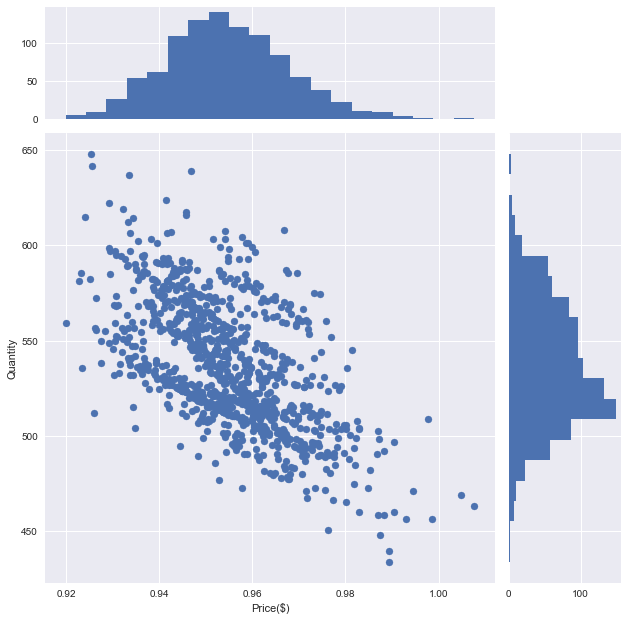

In [24]:
# scatterplot of optimal price and quantity with histograms on both axes
x = plot_data.price
y = plot_data.quantity

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
scatter_hist(x, y, ax, ax_histx, ax_histy)

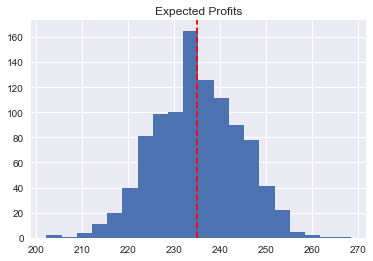

In [25]:
# histogram of expectation of profits
plt.hist(plot_data.profit, bins=bins)
plt.title('Expected Profits')
plt.axvline(x=plot_data.profit.mean(), linestyle='--', color='r')
plt.show()

### 8. You work for a publishing company. Your boss has been using the standard NV model to set printing decisions using the dataset given. Is your boss’ model as good as this one? Could you increase revenue by switching models for production/pricing decisions? Describe the advantages and disadvantages of both techniques. 

standard NV model: $p$ is fixed (we assumed it to be 1) and other costs such as $t$ and $g$ are also included. 

In [26]:
# parameters
p = 1  # fixed price
c = 0.5
g = 0.75
t = 0.15
n = len(data)
nsim = 1000

baseline_quantity = []
baseline_profit = []

for i in range(nsim):
    # bootstrap sample
    idx = np.random.choice(data.index, size=n, replace=True)
    new_data = data.iloc[idx].reset_index(drop=True)
    
    # decision variables: q, h1, h2, ..., hn
    obj = np.zeros(n+1)
    obj[1:] = 1/n

    lb = np.zeros(n+1)
    lb[1:] = -np.inf  # h_i can be negative, but q is greater than 0

    rhs = np.zeros(2*n)
    A = np.zeros((2*n, n+1))
    for row in range(n):
        Di = new_data['demand'][row]

        rhs[row*2] = (1+t)*Di
        rhs[row*2+1] = (1-g)*Di

        A[[row*2,row*2+1], 0] = t+c, c-g
        A[[row*2,row*2+1], row+1] = 1
        
    spMod = gp.Model()
    spMod_x = spMod.addMVar(len(obj), lb=lb)
    spMod_con = spMod.addConstr(A @ spMod_x <= rhs)
    spMod.setObjective(obj @ spMod_x,sense=gp.GRB.MAXIMIZE)
    spMod.Params.OutputFlag = 0
    spMod.optimize()
    
    q = spMod_x.x[0]
    profit = spMod.objVal
    baseline_quantity.append(q)
    baseline_profit.append(profit)

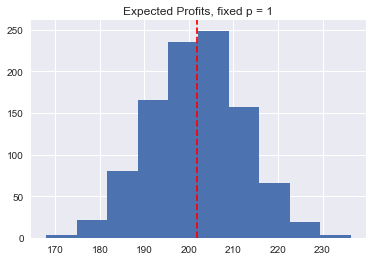

In [27]:
plt.hist(baseline_profit)
plt.title('Expected Profits, fixed p = 1')
plt.axvline(x=np.array(baseline_profit).mean(), linestyle='--', color='r')
plt.show()

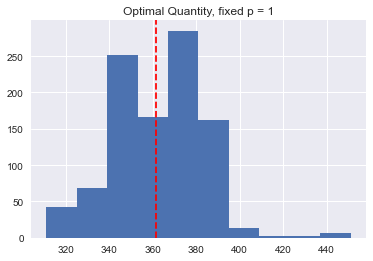

In [28]:
plt.hist(baseline_quantity)
plt.title('Optimal Quantity, fixed p = 1')
plt.axvline(x=np.array(baseline_quantity).mean(), linestyle='--', color='r')
plt.show()